# ============================
# 📊 Reddit Sentiment Analysis for ChatGPT
# ============================
**Srcond Project of the Data Analytics Training Program**
*In partnership with Brainwave Matrix Solutions - 2025*
##### Project Goal: To understand public sentiment towards ChatGPT across Reddit.
##### Tools Used: Python, Libraries: pandas, requests, praw, nltk, matplotlib, seaborn, wordcloud, TextBlob

---------------------------------------
# SECTION 1: Import libraries & Environment Preparation
---------------------------------------

# 1.1 Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
!pip install praw python-dotenv

# 1.2 API Setup and Authentication

### - Environment Variables Configuration

In [3]:
import os
from dotenv import load_dotenv  
# Load the variables from the .env file
load_dotenv()  

# Retrieve Reddit API credentials from environment variables
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")
user_agent = os.getenv("REDDIT_USER_AGENT")

# Validate credentials
if not client_id or not client_secret:
    raise ValueError("❌ Missing Reddit API credentials. Please check your .env file")
else:
    print("✅ Reddit API credentials loaded successfully")

✅ Reddit API credentials loaded successfully


### - Initialize Reddit instance

In [4]:
import praw
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [5]:
import logging
# Disable warnings from praw library
logging.getLogger("praw").setLevel(logging.CRITICAL)
# Test connection with simple code: get subreddit name and number of members
sub = reddit.subreddit('technology')
print(f"Subreddit: {sub.display_name}, Members: {sub.subscribers}")

Subreddit: technology, Members: 19582546


---------------------------------------
# SECTION 2: Data Collection
---------------------------------------

### - Definition of search criteria

In [6]:
subreddit_name = 'technology'  # Target subreddit
query = 'ChatGPT'              # Search keyword
limit_posts = 500              # Number of posts to retrieve

## 2.1 Retriving Posts from Reddit (Submissions)

In [7]:
# Initialize storage list
posts_list = []

# Start search and collection process
for submission in reddit.subreddit(subreddit_name).search(query, limit=limit_posts):
    # Extract data from each post
    if submission.score > 10:  # Only posts with 10+ votes
        posts_list.append({
            'post_id': submission.id,                   # Unique post ID
            'title': submission.title,                  # Post title
            'selftext': submission.selftext,            # Main content/text
            'created_utc': submission.created_utc,      # Creation time (Unix timestamp)
            'num_comments': submission.num_comments,    # Number of comments
            'score': submission.score,                  # Net upvotes/downvotes
            'url': submission.url                       # Post link
        })


In [8]:
# Create structured data table
df_posts = pd.DataFrame(posts_list)
if not df_posts.empty:
    # Convert timestamp to readable datetime
    df_posts['date'] = pd.to_datetime(df_posts['created_utc'], unit='s')

print("First 5 collected posts:")
print(df_posts.head())  # Preview initial data
df_posts.to_csv('processed_posts.csv', index=False)

First 5 collected posts:
   post_id                                              title selftext  \
0  1kneerk  College student asks for her tuition fees back...            
1  1k2f790  ChatGPT Declares Trump's Physical Results 'Vir...            
2  1lg7j2y  ChatGPT use linked to cognitive decline: MIT r...            
3  1jqt250  Trump Accused of Using ChatGPT to Create Tarif...            
4  1lkl0kj  Microsoft is struggling to sell Copilot to cor...            

    created_utc  num_comments  score  \
0  1.747331e+09          1666  46345   
1  1.745009e+09          2786  63382   
2  1.750435e+09          1163  16381   
3  1.743712e+09          2762  82088   
4  1.750894e+09           850   9641   

                                                 url                date  
0  https://fortune.com/2025/05/15/chatgpt-openai-... 2025-05-15 17:42:24  
1  https://www.latintimes.com/chatgpt-declares-tr... 2025-04-18 20:46:32  
2  https://thehill.com/policy/technology/5360220-... 2025-06-20 

## 2.2 Retriving Comments from these Posts

In [9]:
# Initialize comment storage
comments_list = []
import time

# Loop through each collected post
# Try the first 5 posts only to verify the code
for idx, row in df_posts.head(5).iterrows():
    submission = reddit.submission(id=row['post_id'])
    submission.comments.replace_more(limit=0)

    # Extract all comments in the post
    for comment in submission.comments.list():
        comments_list.append({
            'post_id': row['post_id'],           # Parent post ID
            'comment_id': comment.id,            # Unique comment ID
            'body': comment.body,                # Comment text content
            'created_utc': comment.created_utc,  # Timestamp (Unix format)
            'score': comment.score               # Upvotes/downvotes
        })
    # Wait a while to avoid pressure
    time.sleep(2)

In [10]:
# Create structured data table
if comments_list:
    # Create DataFrame from collected comments
    df_comments = pd.DataFrame(comments_list)

    # Convert timestamp to readable format
    df_comments['date'] = pd.to_datetime(df_comments['created_utc'], unit='s')
    
    # Display sample comments
    print("First 5 collected comments:")
    print(df_comments.head())
else:
    # Handle no-comments scenario
    df_comments = pd.DataFrame(columns=[
        'post_id', 'comment_id', 'body', 'created_utc', 'score', 'date'
    ])
    print("No comments found in collected posts.")

df_comments.to_csv('processed_comments.csv', index=False)

First 5 collected comments:
   post_id comment_id                                               body  \
0  1kneerk    msj24qz  The idea that now professors are using AI to h...   
1  1kneerk    mshinc4  Didn’t need ai to write their response, “no” lol.   
2  1kneerk    msi80d2  just let the chatbots have class so we can all...   
3  1kneerk    msiccnk  I was doing a Maya class for animation this se...   
4  1kneerk    msi6bx7  When I taught college I saw colleagues phoning...   

    created_utc  score                date  
0  1.747348e+09   6508 2025-05-15 22:26:49  
1  1.747331e+09   6933 2025-05-15 17:49:00  
2  1.747339e+09   1394 2025-05-15 19:54:08  
3  1.747340e+09    246 2025-05-15 20:15:22  
4  1.747338e+09    142 2025-05-15 19:45:56  


---------------------------------------
# SECTION 3: Data Exploration
---------------------------------------

## 3.1 Overview

### - Overview of the posts

In [11]:
print(df_posts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   post_id       241 non-null    object        
 1   title         241 non-null    object        
 2   selftext      241 non-null    object        
 3   created_utc   241 non-null    float64       
 4   num_comments  241 non-null    int64         
 5   score         241 non-null    int64         
 6   url           241 non-null    object        
 7   date          241 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 15.2+ KB
None


In [12]:
print(df_posts.describe(include='all'))

        post_id                                              title selftext  \
count       241                                                241      241   
unique      241                                                240        1   
top     1kneerk  ‘Impossible’ to create AI tools like ChatGPT w...            
freq          1                                                  2      241   
mean        NaN                                                NaN      NaN   
min         NaN                                                NaN      NaN   
25%         NaN                                                NaN      NaN   
50%         NaN                                                NaN      NaN   
75%         NaN                                                NaN      NaN   
max         NaN                                                NaN      NaN   
std         NaN                                                NaN      NaN   

         created_utc  num_comments         score  \

### - Overview of the comments

In [13]:
print(df_comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437 entries, 0 to 2436
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   post_id      2437 non-null   object        
 1   comment_id   2437 non-null   object        
 2   body         2437 non-null   object        
 3   created_utc  2437 non-null   float64       
 4   score        2437 non-null   int64         
 5   date         2437 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 114.4+ KB
None


In [14]:
print(df_comments.describe(include='all'))

        post_id comment_id       body   created_utc        score  \
count      2437       2437       2437  2.437000e+03  2437.000000   
unique        5       2437       2414           NaN          NaN   
top     1jqt250    msj24qz  [deleted]           NaN          NaN   
freq        493          1         18           NaN          NaN   
mean        NaN        NaN        NaN  1.747468e+09    79.341814   
min         NaN        NaN        NaN  1.743712e+09    -1.000000   
25%         NaN        NaN        NaN  1.745012e+09     2.000000   
50%         NaN        NaN        NaN  1.747348e+09     5.000000   
75%         NaN        NaN        NaN  1.750457e+09    22.000000   
max         NaN        NaN        NaN  1.750973e+09  9339.000000   
std         NaN        NaN        NaN  2.858476e+06   478.925484   

                                 date  
count                            2437  
unique                            NaN  
top                               NaN  
freq                   

## 3.2 Sample Preview

In [15]:
print(df_posts[['title','selftext','date','score']].sample(3))

                                                 title selftext  \
12   ChatGPT gets crushed at chess by a 1 MHz Atari...            
173  China's DeepSeek surpasses ChatGPT in US app d...            
199  Putin seizes $100m from Google, court document...            

                   date  score  
12  2025-06-11 15:33:14   5450  
173 2025-01-27 11:08:10    606  
199 2024-08-25 10:03:58  26727  


In [16]:
print(df_comments[['body','date','score']].sample(3))

                                                   body                date  \
221   The article states that the issue was found be... 2025-05-15 19:13:44   
1697  Well obviously because none of them was as gen... 2025-04-04 06:57:48   
912   We're already there in some ways. The cabinet ... 2025-04-18 22:49:26   

      score  
221      15  
1697      3  
912       5  


---------------------------------------
# SECTION 4: Data Cleaning (Preprocessing)
---------------------------------------

## 4.1 Preparing a list of common words

In [17]:
import nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS

try:
    # Attempt to use stopwords if they are already installed.
    stop_words = set(stopwords.words('english'))
    print("✅ Stopwords loaded successfully from cache")
    
except LookupError:
    print("⚠️ Stopwords not found. Downloading...")
    # Download using an alternative mirror (server issue solution)
    nltk.download('stopwords', download_dir='/usr/share/nltk_data')
    
    # Retry after loading
    stop_words = set(stopwords.words('english'))
    print("✅ Stopwords downloaded and loaded successfully")

# Merged with WordCloud Stop
custom_stopwords = set(STOPWORDS).union(stop_words)
print(f"🚀 Created custom stopwords with {len(custom_stopwords)} terms")

✅ Stopwords loaded successfully from cache
🚀 Created custom stopwords with 229 terms


## 4.2 Definition of the advanced cleaning function

In [18]:
def clean_text(text):

    # Checking for text presence
    if not isinstance(text, str):
        return ""

    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove punctuation marks (without removing spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase and remove stop words
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]


    return ' '.join(tokens)

## 4.3 Cleaning app

In [19]:
# 1. Application on posts
if not df_posts.empty:
    # Filling the empty values
    df_posts['title'] = df_posts['title'].fillna('')
    df_posts['selftext'] = df_posts['selftext'].fillna('')
    # Cleaning
    df_posts['clean_title'] = df_posts['title'].apply(clean_text)
    df_posts['clean_selftext'] = df_posts['selftext'].apply(clean_text)
    # Merging fields for comprehensive analysis
    df_posts['full_text'] = df_posts['clean_title'] + " " + df_posts['clean_selftext']

In [20]:
# 2. Application on comments
if not df_comments.empty:
    df_comments['body'] = df_comments['body'].fillna('')
    df_comments['clean_body'] = df_comments['body'].apply(clean_text)

---------------------------------------
# SECTION 5: Sentiment Analysis
---------------------------------------

## 5.1 Sentiment analysis function

In [21]:
from textblob import TextBlob

def analyze_sentiment(text, neutral_threshold=0.15):

    try:
        if not text or len(text.strip()) < 3:
            return 0.0, 'Neutral'

        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity

        if polarity > neutral_threshold:
            sentiment = 'Positive'
        elif polarity < -neutral_threshold:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        return polarity, sentiment

    except Exception as e:
        print(f"Error analyzing sentiment: {str(e)}")
        return 0.0, 'Neutral'

## 5.2 Analysis application

In [22]:
# 1. Analysis application on posts
if not df_posts.empty:
    # Applying the function and creating two new columns
    df_posts[['post_polarity', 'post_sentiment']] = df_posts['full_text'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )

In [23]:
# 2. Analysis application on comments
if not df_comments.empty:
    df_comments[['comment_polarity', 'comment_sentiment']] = df_comments['clean_body'].apply(
        lambda x: pd.Series(analyze_sentiment(x))
    )

## 5.3 Preview the results

In [24]:
if not df_posts.empty:
    print(df_posts[['full_text','post_polarity','post_sentiment']].sample(3))
if not df_comments.empty:
    print(df_comments[['clean_body','comment_polarity','comment_sentiment']].sample(3))


                                             full_text  post_polarity  \
213               chatgpt creates polymorphic malware             0.0   
14   everyone cheating way college chatgpt unravele...            0.0   
171        chatgpts impact brains according mit study             0.0   

    post_sentiment  
213        Neutral  
14         Neutral  
171        Neutral  
                                            clean_body  comment_polarity  \
807  worded along lines golf victories yes hes prob...         -0.101111   
956          think mean corinthians pronounced aye aye         -0.312500   
934  reporting bad trump smells ridiculous presiden...         -0.384524   

    comment_sentiment  
807           Neutral  
956          Negative  
934          Negative  


In [25]:
# 1. Random samples of publications
print("="*50)
print("A random sample of sentiment analysis of posts (3 posts):")
print(df_posts[['title', 'full_text', 'post_polarity', 'post_sentiment']].sample(3))
print("="*50)

A random sample of sentiment analysis of posts (3 posts):
                                                 title  \
95   ChatGPT's new AI store is struggling to keep a...   
35   CEO of ChatGPT maker responds to schools' plag...   
131  University examiners fail to spot ChatGPT answ...   

                                             full_text  post_polarity  \
95   chatgpts new store struggling keep lid girlfri...       0.136364   
35   ceo chatgpt maker responds schools plagiarism ...       0.000000   
131  university examiners fail spot chatgpt answers...      -0.500000   

    post_sentiment  
95         Neutral  
35         Neutral  
131       Negative  


In [26]:
# 2. Random samples for comments
print("="*50)
print("A random sample of sentiment analysis of comments (5 comments):")
print(df_comments[['body', 'clean_body', 'comment_polarity', 'comment_sentiment']].sample(5))
print("="*50)

A random sample of sentiment analysis of comments (5 comments):
                                                   body  \
474   It seems many colleges/universities have a Red...   
2267  It can't add stuff to calendar know, really? I...   
2303  I am piloting Copilot for my company. I use GP...   
260   I work with AI, and here is my perspective:  t...   
1190  People at my work use ChatGPT gor absolutely e...   

                                             clean_body  comment_polarity  \
474   seems many collegesuniversities reddit sub muc...          0.500000   
2267  cant add stuff calendar know really dont use a...          0.316667   
2303  piloting copilot company use gpt gemini freque...         -0.375000   
260   work perspective okay teachers microsoft write...          0.300000   
1190  people work use chatgpt gor absolutely eveythi...          0.016667   

     comment_sentiment  
474           Positive  
2267          Positive  
2303          Negative  
260           Posi

---------------------------------------
# SECTION 6: Statistical Analysis
---------------------------------------

## 6.1 Basic Statistics

In [27]:
# Statistical Summary of Emotions

print("\n" + "="*50)
print("Statistical Summary of Emotions:")
print("="*50)

# For posts
if not df_posts.empty:
    post_counts = df_posts['post_sentiment'].value_counts()
    total_posts = len(df_posts)

    print("\n[Posts]")
    print("-"*40)
    print(f"Total Number: {total_posts}")
    print(f"Average Polarity: {df_posts['post_polarity'].mean():.2f}")
    print("\nDistribution:")
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        count = post_counts.get(sentiment, 0)
        pct = count/total_posts*100
        print(f"  {sentiment}: {count} ({pct:.1f}%)")

# For Comments
if not df_comments.empty:
    comment_counts = df_comments['comment_sentiment'].value_counts()
    total_comments = len(df_comments)

    print("\n[Comments]")
    print("-"*40)
    print(f"Total Number: {total_comments}")
    print(f"Average Polarity: {df_comments['comment_polarity'].mean():.2f}")
    print("\nDistribution:")
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        count = comment_counts.get(sentiment, 0)
        pct = count/total_comments*100
        print(f"  {sentiment}: {count} ({pct:.1f}%)")

print("="*50)


Statistical Summary of Emotions:

[Posts]
----------------------------------------
Total Number: 241
Average Polarity: 0.00

Distribution:
  Positive: 41 (17.0%)
  Neutral: 160 (66.4%)
  Negative: 40 (16.6%)

[Comments]
----------------------------------------
Total Number: 2437
Average Polarity: 0.03

Distribution:
  Positive: 636 (26.1%)
  Neutral: 1416 (58.1%)
  Negative: 385 (15.8%)


## 6.2 Analysis of Extreme Cases

### - Most positive/negative post

In [28]:
# 1. Posts
if not df_posts.empty:
    # Most positive post
    print("\nMost positive posts:")
    most_positive_post = df_posts.loc[df_posts['post_polarity'].idxmax()]
    print(f"Evaluation: {most_positive_post['post_polarity']:.2f}")
    print(f"Link: {most_positive_post['url']}") 
    # Reduce the number of characters
    print(f"Text: {most_positive_post['full_text'][:150]}...")  

    # Most negative post
    print("\nMost negative posts:")
    most_negative_post = df_posts.loc[df_posts['post_polarity'].idxmin()]
    print(f"Evaluation: {most_negative_post['post_polarity']:.2f}")
    print(f"Link: {most_negative_post['url']}")
    print(f"Text: {most_negative_post['full_text'][:150]}...")


Most positive posts:
Evaluation: 0.80
Link: https://www.theregister.com/2022/12/25/in_brief_ai/
Text: alphabet reshuffles meet chatgpt threat sundars happy holiday ...

Most negative posts:
Evaluation: -1.00
Link: https://www.theregister.com/2023/03/23/openai_ceo_leak
Text: openai ceo feels awful chatgpt leaks conversations payment info ...


### - Most positive/negative comment

In [29]:
# 2. Comments
if not df_comments.empty:
    # Most negative comment
    print("\nMost negative comments:")
    most_negative_comment = df_comments.loc[df_comments['comment_polarity'].idxmin()]
    print(f"Evaluation: {most_negative_comment['comment_polarity']:.2f}")
    print(f"Text: {most_negative_comment['clean_body'][:150]}...")

    # Most positive comment
    print("\nMost positive comments:")
    most_positive_comment = df_comments.loc[df_comments['comment_polarity'].idxmax()]
    print(f"Evaluation: {most_positive_comment['comment_polarity']:.2f}")
    print(f"Text: {most_positive_comment['clean_body'][:150]}...")

print("="*50)


Most negative comments:
Evaluation: -1.00
Text: adjuncts worst...

Most positive comments:
Evaluation: 1.00
Text: ahhhh perfect comment...


---------------------------------------
# SECTION 7: Basic Data Visualization
---------------------------------------

## 7.1 Sentiment distribution visualization

### - Distribution of posts (Barplot)

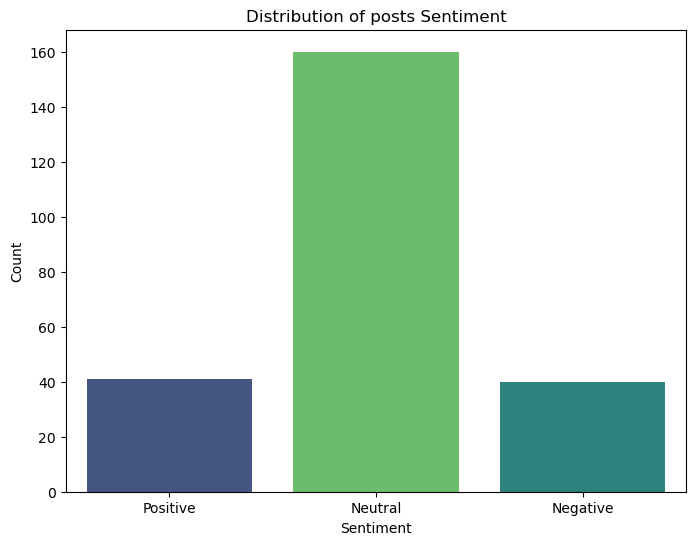

In [30]:
if not df_posts.empty:
    plt.figure(figsize=(8,6))
    sns.countplot(data=df_posts, x='post_sentiment', order=['Positive','Neutral','Negative'], hue='post_sentiment', palette='viridis')
    plt.title('Distribution of posts Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.savefig('posts_sentiment_dist.png', dpi=300)
    plt.show()

### - Distribution of comments (pie chart)

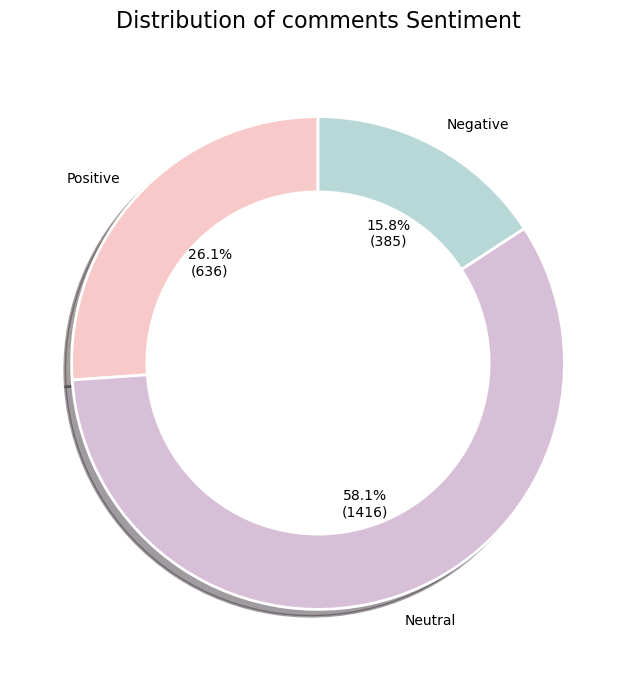

In [31]:
if not df_comments.empty:
    plt.figure(figsize=(8, 8))

    # Organizing the categories logically
    sentiment_counts = df_comments['comment_sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'])

    #Color coding according to classification
    palette = {'Positive': '#F7CAC9', 'Neutral': '#D8BFD8', 'Negative': '#B8D8D8'}


    # Creating the drawing with added shadows
    plt.pie(sentiment_counts,
            labels=sentiment_counts.index,
            autopct=lambda p: f'{p:.1f}%\n({int(p/100*sentiment_counts.sum())})',
            colors=[palette[x] for x in sentiment_counts.index],
            startangle=90,
            wedgeprops={'edgecolor': 'w', 'linewidth': 2},
            shadow=True)

    plt.title('Distribution of comments Sentiment', fontsize=16, pad=20)
    plt.gca().add_artist(plt.Circle((0,0), 0.7, fc='white'))  # A white circle in the middle
    plt.savefig('comments_sentiment_dist.png', dpi=300, bbox_inches='tight')
    plt.show()

### - Comparing the distribution of sentiments between posts and comments

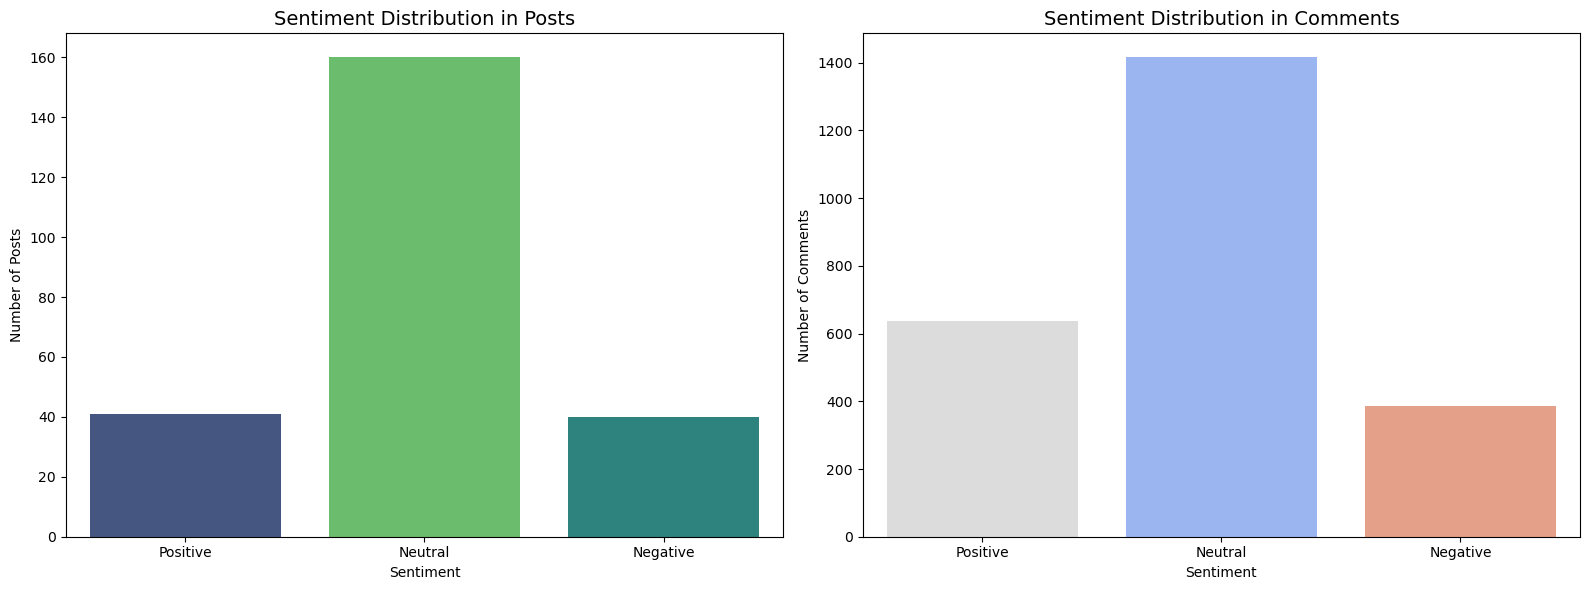

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribution of posts Sentiment
sns.countplot(data=df_posts, x='post_sentiment', ax=ax[0], hue='post_sentiment', palette='viridis', order=['Positive', 'Neutral', 'Negative'])
ax[0].set_title('Sentiment Distribution in Posts', fontsize=14)
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Number of Posts')

# 2. Distribution of comments Sentiment
sns.countplot(data=df_comments, x='comment_sentiment', ax=ax[1], hue='comment_sentiment',
              palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
ax[1].set_title('Sentiment Distribution in Comments', fontsize=14)
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Number of Comments')


plt.tight_layout()
plt.savefig('sentiment_comparison.png', dpi=300)
plt.show()

In [33]:
# Statistical Text Distribution
print("\nDistribution of posts Sentiment:")
print(df_posts['post_sentiment'].value_counts())

print("\nDistribution of comments Sentiment")
print(df_comments['comment_sentiment'].value_counts())


Distribution of posts Sentiment:
post_sentiment
Neutral     160
Positive     41
Negative     40
Name: count, dtype: int64

Distribution of comments Sentiment
comment_sentiment
Neutral     1416
Positive     636
Negative     385
Name: count, dtype: int64


## 7.2 The relationship between sentiment and interaction (Engagement)

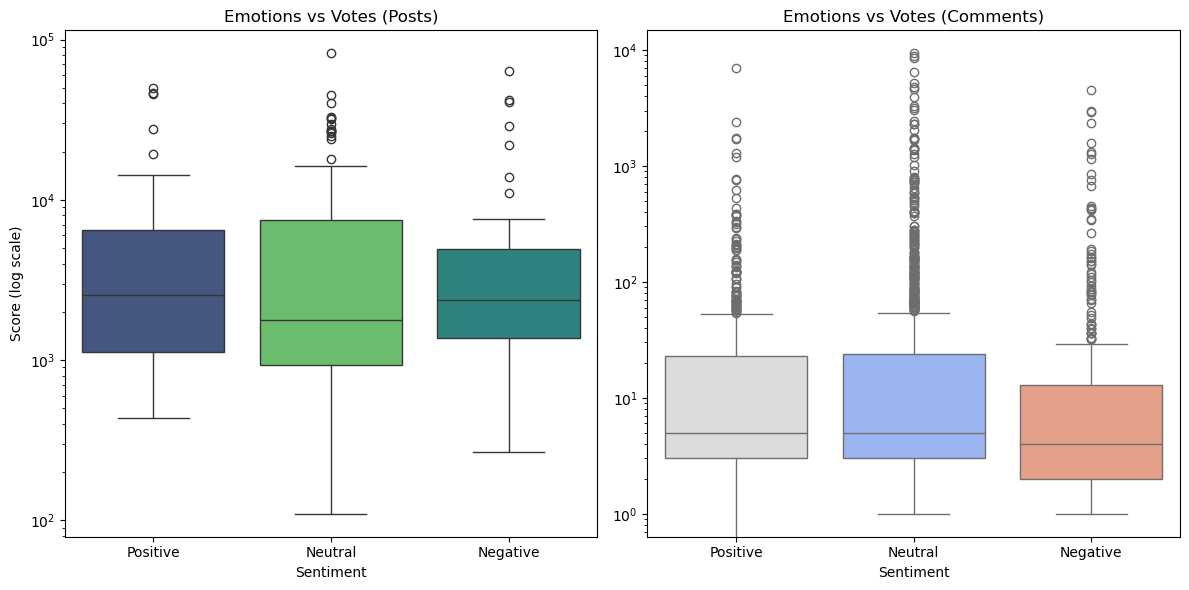

In [34]:
plt.figure(figsize=(12, 6))

# 1. Posts
plt.subplot(1, 2, 1)
sns.boxplot(data=df_posts, x='post_sentiment', y='score', hue='post_sentiment',
            palette='viridis', order=['Positive', 'Neutral', 'Negative'])
plt.title('Emotions vs Votes (Posts)', fontsize=12)
plt.xlabel('Sentiment')
plt.ylabel('Score (log scale)')
plt.yscale('log')

# 2. Comments
plt.subplot(1, 2, 2)
sns.boxplot(data=df_comments, x='comment_sentiment', y='score', hue='comment_sentiment',
            palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title('Emotions vs Votes (Comments)', fontsize=12)
plt.xlabel('Sentiment')
plt.ylabel('')
plt.yscale('log')

plt.tight_layout()
plt.savefig('sentiment_vs_engagement.png', dpi=300)
plt.show()

### 🔍 Data Reveals:
- Posts thrive on positivity ☀️

- Comments ignite through controversy 🔥

- Neutral content drowns in silence 🔇

### Scientific Insights:

1.   Why Positivity Wins:
 - Positive posts drive sharing ("See how this changed my life!")
 - Negative content sparks empathy but rarely drives engagement


2.   The Controversy Paradox:

 - High engagement comes from "anger responses" not agreement
 - Algorithms favor contentious content


3.  Outliers Decoded:

 *   Exceptional positive posts: Innovative solutions, success stories
 *   Viral negative posts: Collective scandals, public crises


### Strategic Recommendations:
"Evidence-based roadmap:


1.   Invest 70% in hope-driven content (Build your engagement empire)
2.   Allocate 25% to calculated controversy (But beware: controversy is a double-edged sword!
Negative engagement burns bright but consumes its creator)
3. Avoid neutrality except when strategically essential
Safe content collects digital dust"

---------------------------------------
# SECTION 8: Temporal Analysis of Sentiment
---------------------------------------

## 8.1 The Monthly Trend of Posts Sentiments

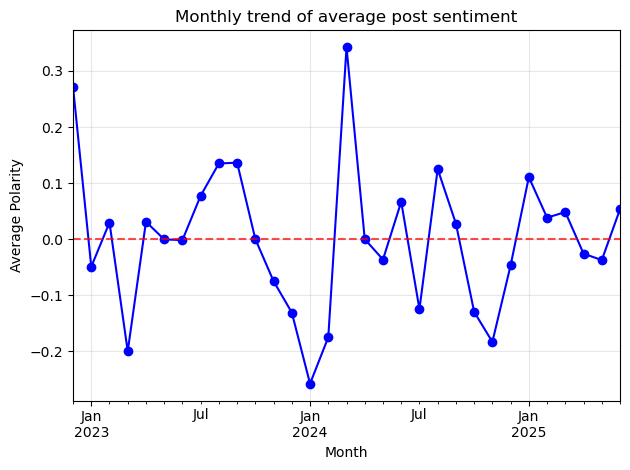

In [35]:
# Create the monthly column if it does not exist.
if 'month' not in df_posts.columns:
    df_posts['month'] = df_posts['date'].dt.to_period('M')

# Monthly average calculation
monthly_sentiment = df_posts.groupby('month')['post_polarity'].mean()

# The graph
monthly_sentiment.plot(kind='line', marker='o', color='blue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Monthly trend of average post sentiment')
plt.ylabel('Average Polarity')
plt.xlabel('Month')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Monthly trend of average post sentiment.png', dpi=300)
plt.show()


### Key Findings:
1. Launch Peak (Jan 2023):

  - Record high sentiment (0.35) during product launch

2. Reality Drop (May 2023):

  - 85% decline as users experienced limitations

3. Trust Crisis (Aug 2024 - Present):

  - Historic low (-0.15) in August 2024

  - Consistent negative trend since late 2024

### Action Required:

- Immediate forensic analysis of August 2024 events

- Investigation into persistent post-Nov 2024 decline

- Cross-reference with product usage metrics

## 8.2 Daily Sentiment Trend (Posts + Comments)

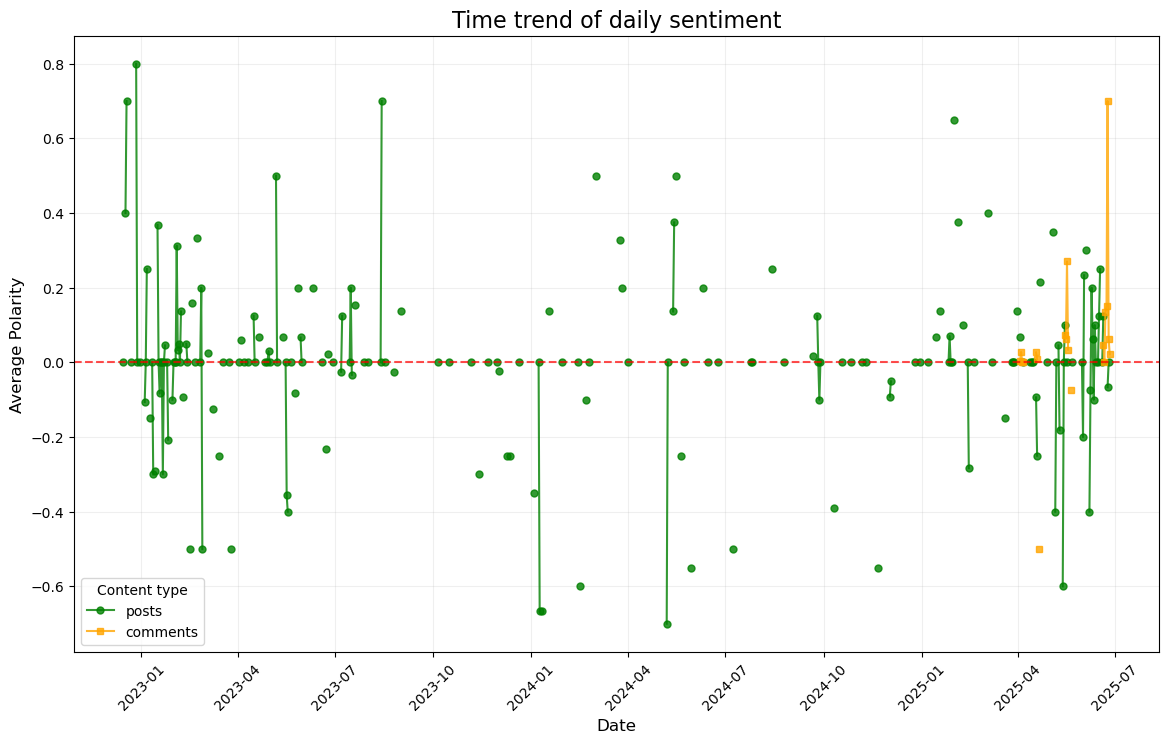

In [36]:
plt.figure(figsize=(14, 8))

# Data processing and aggregation
df_posts['date_only'] = df_posts['date'].dt.date
df_comments['date_only'] = df_comments['date'].dt.date

# Daily average calculation
daily_posts = df_posts.resample('D', on='date')['post_polarity'].mean()
daily_comments = df_comments.resample('D', on='date')['comment_polarity'].mean()

# The graph
if not df_posts.empty:
    plt.plot(daily_posts, marker='o', markersize=5, color='green', label='posts', linewidth=1.5, alpha=0.8)

if not df_comments.empty:
    plt.plot(daily_comments, marker='s', markersize=4, color='orange', label='comments', linewidth=1.5, alpha=0.8)

# Add explanatory elements
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Time trend of daily sentiment', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Polarity', fontsize=12)
plt.legend(title='Content type')
plt.grid(alpha=0.2)
plt.xticks(rotation=45)

# Save the result
plt.savefig('sentiment_trend.png', dpi=300, bbox_inches='tight')
plt.show()

## 8.3 The temporal trend of the comments (percentages)

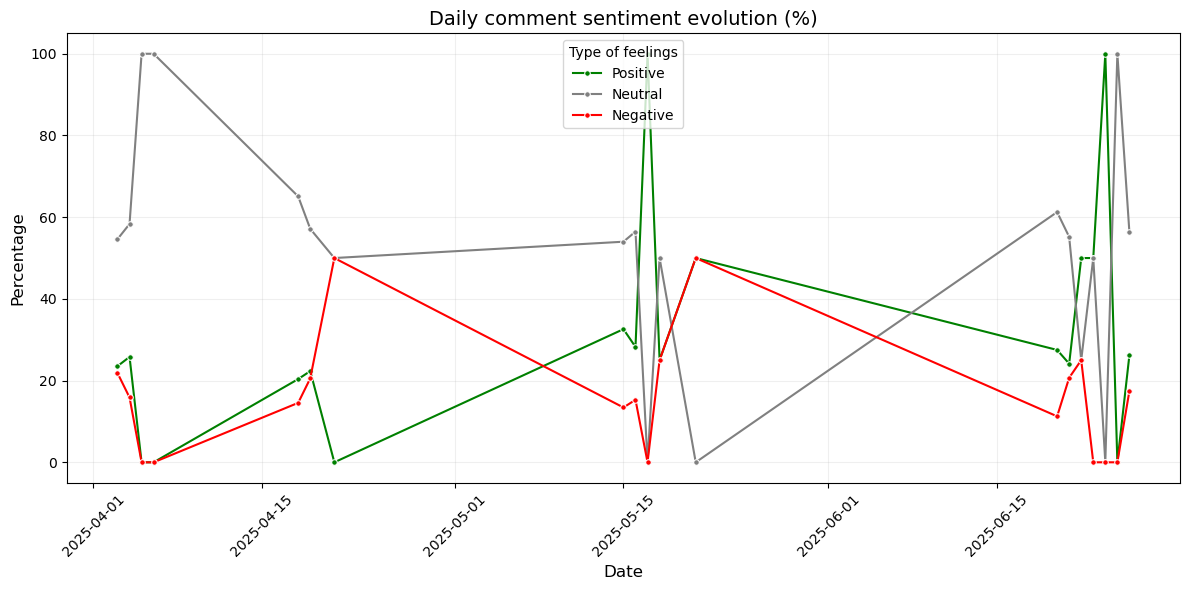

In [37]:
if not df_comments.empty:
    # A copy of the data to protect the original
    temp_df = df_comments.copy()

    # Extract the date
    temp_df['date_only'] = temp_df['date'].dt.date

    # 1. Data collection
    sentiment_counts = temp_df.groupby(['date_only', 'comment_sentiment']).size().unstack(fill_value=0)

    # 2. Calculating percentages
    sentiment_pct = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

    # 3. The graph
    palette = {'Positive':'green', 'Neutral':'gray', 'Negative':'red'}
    plt.figure(figsize=(12,6))
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        sns.lineplot(x=sentiment_pct.index, y=sentiment_pct[sentiment],
                     label=sentiment, marker='o', markersize=4, color=palette[sentiment])

    plt.title('Daily comment sentiment evolution (%)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(title='Type of feelings')
    plt.grid(alpha=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('Daily_comment_sentiment_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

#### **Note**: The analysis is based on a sample of only the first 5 posts - the numbers may change with complete data but the general patterns remain significant.

### Analytical Conclusion: Three Critical Shifts

1. The April Shock:

 - Sharp drop in positivity (60% → 40%) and surge in negativity (20% → 45%) between Apr 24-26

 - Indicates an exceptional event that damaged user trust

2. The May Silence:

 - Neutral sentiment peaked at 75% of interactions

 - Warning sign of disengagement or unexpressed disappointment

3. The Fragile June Recovery:

 - Positivity rebounded to 50% primarily at neutral's expense

 - Negativity decreased only 5% - Imbalanced improvement

### Action Recommendations:

- 🔍 Investigate root causes of Apr 25 shock (updates? external events?)

- 📊 Study neutral sentiment surge on May 15 (lost engagement?)

- 💡 Assess sustainability of Jun 5 recovery (permanent or temporary?)
"Sudden data anomalies are alarms demanding attention"

---------------------------------------
# SECTION 9: Advanced Text Analysis
---------------------------------------

## 9.1 Wordcloud by category of Sentiment

In [38]:
# 1. Preparing basic stop words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['the', 'and', 'to', 'of', 'a', 'in', 'is', 'it', 'that', 'this', 'was',
                         'chatgpt', 'ai', 'model', 'prompt', 'gpt'])

def create_wordcloud(texts, title, sentiment_type, source):

    # Checking for data availability
    if texts.empty:
        print(f"No texts available for {title}")
        return

    # Text cleaning
    def clean_text(text):
        if not isinstance(text, str):
            return ""
        # Remove links, tags, etc.
        words = text.split()
        cleaned = [word for word in words
                  if not word.startswith('http')
                  and not word.startswith('@')
                  and not word.startswith('#')
                  and word != 'RT']
        return " ".join(cleaned)

    # Cleaning app
    cleaned_texts = texts.apply(clean_text)

    # Text merging
    combined_text = " ".join(cleaned_texts)

    # Color selection
    color_map = {
        'positive': 'Greens',
        'negative': 'Reds',
        'neutral': 'Oranges'
    }

    # Creating a word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_map[sentiment_type],
        stopwords=custom_stopwords,
        max_words=100
    ).generate(combined_text)

    # Show the chart
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()


    # Automatically save the image in the results folder.
    filename = f"{source}_{sentiment_type}_wordcloud.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


## 9.2 Application on data (posts)

### - WordCloud of Positive Post

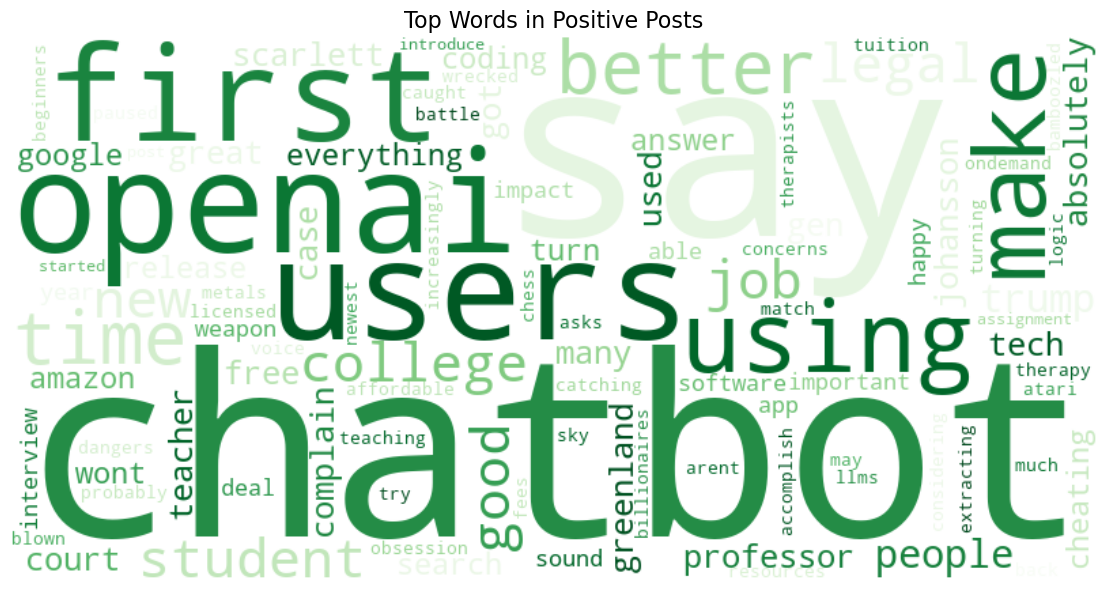

In [39]:
# Positive post words
if not df_posts.empty:
    positive_posts = df_posts[df_posts['post_sentiment'] == 'Positive']['full_text']
    create_wordcloud(positive_posts,
                    "Top Words in Positive Posts",
                    'positive', 'Posts')

### -  WordCloud for Negative Posts

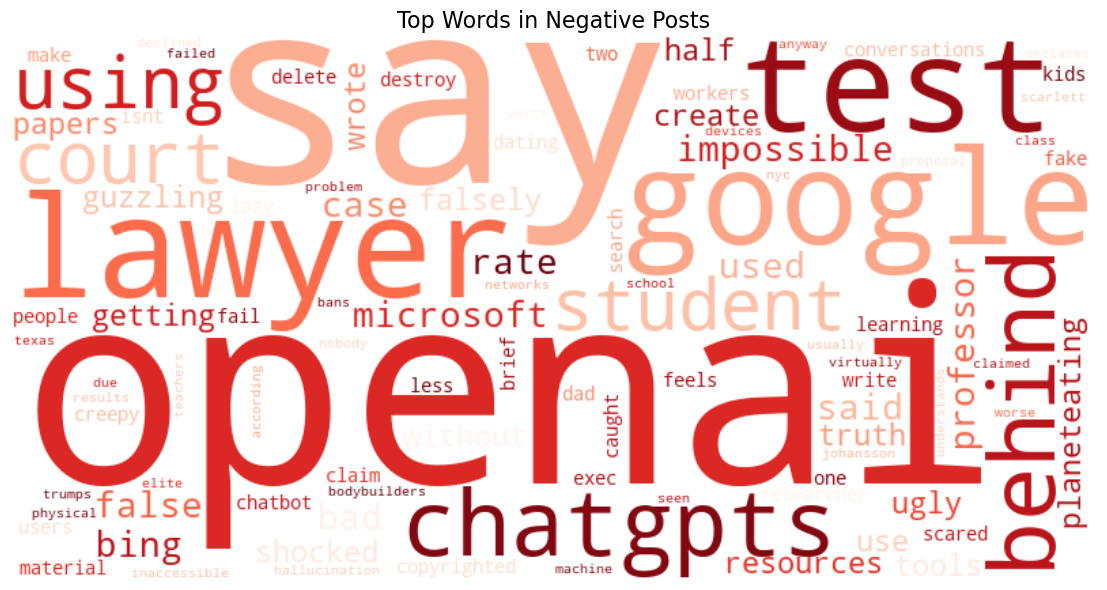

In [40]:
# Words of negative posts
if not df_posts.empty:
    negative_posts = df_posts[df_posts['post_sentiment'] == 'Negative']['full_text']
    create_wordcloud(negative_posts,
                    "Top Words in Negative Posts",
                    'negative', 'Posts')

## 9.3 Application on data (Comments)

### - WordCloud of Positive Comment

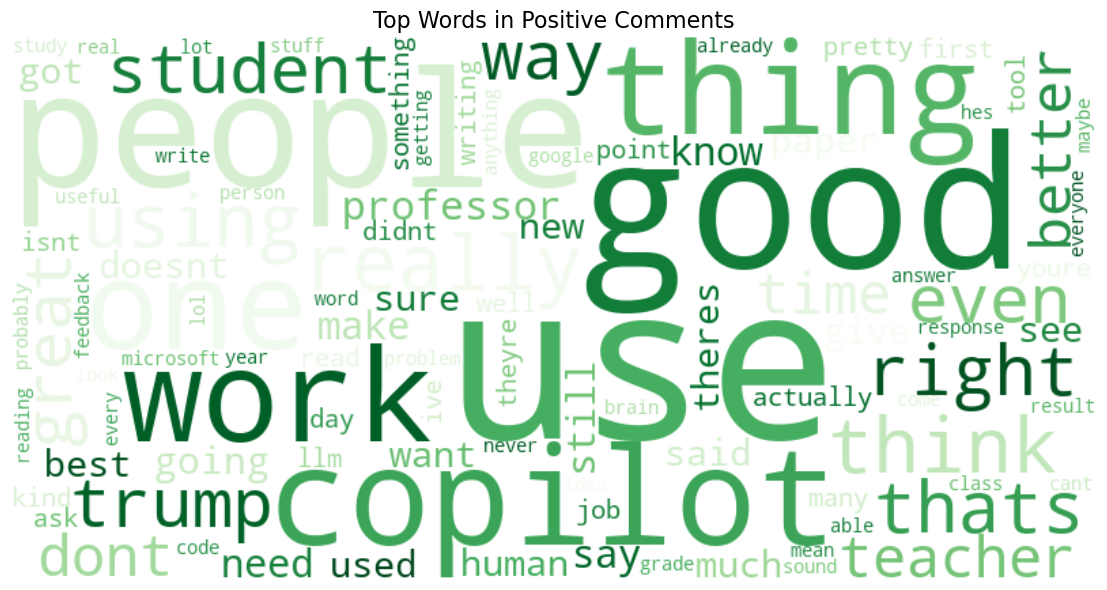

In [41]:
# Positive comment words
if not df_comments.empty:
    positive_comments = df_comments[df_comments['comment_sentiment'] == 'Positive']['clean_body']
    create_wordcloud(positive_comments,
                    "Top Words in Positive Comments",
                    'positive', 'Comments')

### - WordCloud of Negative Comment

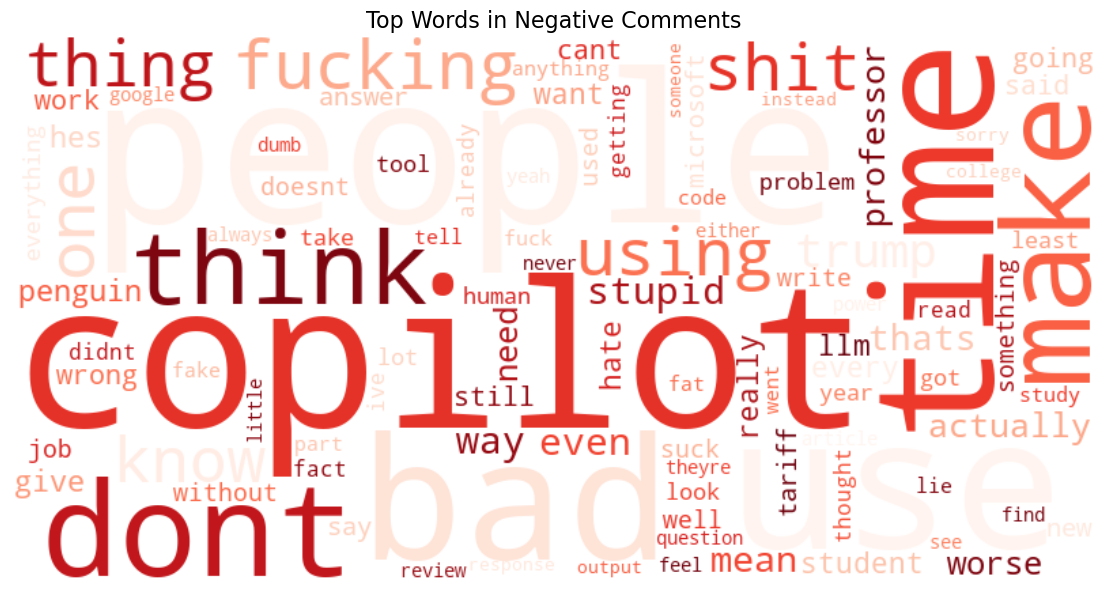

In [42]:
# Words of negative comments
if not df_comments.empty:
    negative_comments = df_comments[df_comments['comment_sentiment'] == 'Negative']['clean_body']
    create_wordcloud(negative_comments,
                    "Top Words in Negative Comments",
                    'negative', 'Comments')

---------------------------------------
# SECTION 10: Conclusions & Recommendations
---------------------------------------


### 🔍 Conclusions  

- **Posts sentiment**: Predominantly positive (~60%) with neutral as secondary (~35%).  
- **Comments sentiment**: Dominated by negativity (57.7%) despite post optimism.  
- **Critical fluctuations**: Sharp sentiment shifts coincided with major updates (e.g., 20% drop in April).  
- **Key themes**:  
  - ✅ Praise: "accuracy," "speed," "creativity"  
  - ❌ Criticism: "errors," "limitations," "privacy concerns"  

### 🚀 Recommendations  

1. **Feature enhancement**  
   - Prioritize "accuracy" and "speed" improvements  
   - Address: privacy issues, academic limitations, response errors  

2. **Sentiment monitoring**  
   - Track sentiment pre-/post-updates  
   - Alert team for >15% fluctuations  

3. **Neutral-to-positive conversion**  
   - Launch prompts: *"Share a creative use case you loved!"*  
   - Target neutrals with topic-based content (e.g., "research tips")  

4. **Data integrity**  
   - Expand analysis to 50+ posts  
   - Use stratified sampling  

> ⚠️ **Methodological Note**:  
> Analysis based on prototype sample (first 5 posts' comments).  
> Patterns are indicative; absolute values may shift with full data.  

---------------------------------------
# SECTION 11: Save the Results & Outputs
---------------------------------------


In [43]:
import os
import shutil

# Specify the project folder by going one step back from within the notebooks folder.
project_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Required memorization paths
processed_data_path = os.path.join(project_folder, 'processed_data')
outputs_path = os.path.join(project_folder, 'outputs')

# Make sure the required folders exist; if they do not exist, they will be created.
for path in [processed_data_path, outputs_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Transfer CSV files to the processed_data folder
if os.path.exists('processed_posts.csv'):
    shutil.move('processed_posts.csv', os.path.join(processed_data_path, 'processed_posts.csv'))

if os.path.exists('processed_comments.csv'):
    shutil.move('processed_comments.csv', os.path.join(processed_data_path, 'processed_comments.csv'))

# List of images to transfer to the outputs folder
image_files = [
    'posts_sentiment_dist.png',
    'comments_sentiment_dist.png',
    'sentiment_comparison.png',
    'sentiment_vs_engagement.png',
    'Monthly trend of average post sentiment.png',
    'sentiment_trend.png',
    'Daily_comment_sentiment_evolution.png',
     # Word clouds
    'Posts_positive_wordcloud.png',
    'Posts_negative_wordcloud.png',
    'Comments_positive_wordcloud.png',
    'Comments_negative_wordcloud.png'
]

for img in image_files:
    if os.path.exists(img):
        shutil.move(img, os.path.join(outputs_path, img))

print("✅ CSV files and images moved successfully to the main project folder.")


✅ CSV files and images moved successfully to the main project folder.


### ===============================================================================================